In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d

import pickle

In [2]:
mb_size = 100 # mini-batch size of 100


trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))])


dataset = dset.MNIST("./", download = True,
                     train = True,
                     transform = trans)

test_dataset = dset.MNIST("./", download=True,
                          train=False,
                          transform = trans)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=mb_size,
                                          shuffle=True, num_workers=1,
                                          pin_memory=True)

## 1 Introduction

In [3]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(X):
    return torch.max(torch.zeros_like(X), X)


# this is an example as a reduced version of the pytorch internal RMSprop optimizer
class RMSprop(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1-alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


def model(X, w_h, w_h2, w_o):
    h = rectify(X @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [4]:
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o])


# put this into a training loop over 100 epochs
for i in range(101):
    print("Epoch: {}".format(i+1))
    avg_train_loss = 0.
    for (j, (X, y)) in enumerate(dataloader):
        noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o)
        optimizer.zero_grad()
        # the cross-entropy loss function already contains the softmax
        cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
        avg_train_loss += cost
        cost.backward()
        optimizer.step()

    if i % 10 == 0:
        print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))

        # no need to calculate gradients for validation
        with torch.no_grad():
            avg_test_loss = 0.
            for (k, (X, y)) in enumerate(test_loader):
                noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o)
                cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
                avg_test_loss += cost

            print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))


Epoch: 1
Average Train Loss: 0.39889439940452576
Average Test Loss: 0.3027656078338623
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 0.15847530961036682
Average Test Loss: 0.3246176242828369
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Average Train Loss: 0.10855640470981598
Average Test Loss: 0.3444851040840149
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Average Train Loss: 0.06587997078895569
Average Test Loss: 0.6349341869354248
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Average Train Loss: 0.04680406674742699
Average Test Loss: 0.8158227801322937
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Average Train Loss: 0.04137413948774338
Average Test Loss: 0.7010069489479065
Epoch: 52
Epoch: 53
Epoch: 54
E

## 2 Dropout

In [5]:
# dropout function
def dropout(X, p_drop=0.5):
    if (0 < p_drop < 1):
        bernoulli = torch.bernoulli(torch.empty(X.shape).fill_(p_drop))
        X[bernoulli == 1.0] = 0
        X = X / (1- p_drop)
        return X
    else:
        return X
    
def model_dropout(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X_drop = dropout(X, p_drop_input)
    h = rectify(X_drop @ w_h)
    h_drop = dropout(h, p_drop_hidden)
    h2 = rectify(h_drop @ w_h2)
    h2_drop = dropout(h2, p_drop_hidden)
    pre_softmax = h2_drop @ w_o
    return pre_softmax

w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o])

p_drop_input = 0.3
p_drop_hidden = 0.5

# put this into a training loop over 100 epochs
def training(epochs=100, drop=True):
    train_loss = []
    test_loss = []
    for i in range(epochs + 1):
        print("Epoch: {}".format(i+1))
        avg_train_loss = 0.
        for (j, (X, y)) in enumerate(dataloader):
            if drop:
                noise_py_x = model_dropout(X.reshape(mb_size, 784), w_h, w_h2, w_o, p_drop_input, p_drop_hidden)
            else:
                noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o)
            optimizer.zero_grad()
            # the cross-entropy loss function already contains the softmax
            cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
            avg_train_loss += cost
            cost.backward()
            optimizer.step()

        train_loss.append(float(avg_train_loss / (j + 1)))
        if i % 10 == 0:
            print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))
    
            # no need to calculate gradients for validation
            with torch.no_grad():
                avg_test_loss = 0.
                for (k, (X, y)) in enumerate(test_loader):
                    if drop:
                        # using weight scaling inference for testing
                        noise_py_x = model_dropout(X.reshape(mb_size, 784), p_drop_input * w_h, p_drop_hidden * w_h2,
                                       p_drop_hidden * w_o, p_drop_input, p_drop_hidden)
                    else:
                        noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o)
                    cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
                    avg_test_loss += cost
                test_loss.append(float(avg_test_loss / (k + 1)))
                print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))
    
    train_loss = np.array(train_loss)
    test_loss = np.array(test_loss)
    return train_loss, test_loss

In [7]:
##########
# Task 1:
print("TASK1")
train_loss1, test_loss1 = training(epochs=42, drop=False)

#########
# Task 2:
print("TASK2")
train_loss2, test_loss2 = training(epochs=42)

TASK1
Epoch: 1
Average Train Loss: 0.3943944573402405
Average Test Loss: 0.16676922142505646
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 0.15208664536476135
Average Test Loss: 0.3142150938510895
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Average Train Loss: 0.10455688834190369
Average Test Loss: 0.5621062517166138
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Average Train Loss: 0.06966216117143631
Average Test Loss: 0.46552586555480957
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Average Train Loss: 0.05236726254224777
Average Test Loss: 0.7477063536643982
Epoch: 42
Epoch: 43
TASK2
Epoch: 1
Average Train Loss: 2.519752264022827
Average Test Loss: 0.5199432969093323
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11

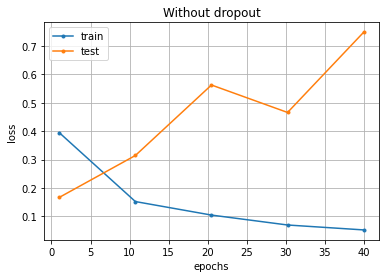

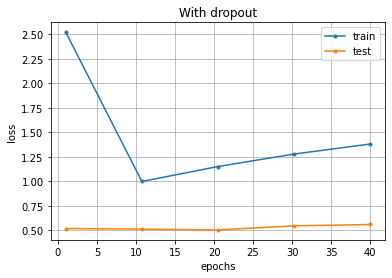

In [8]:
epochs = 40
epoch_list = np.linspace(1, epochs, int(epochs/10)+1)

plt.figure(0)
plt.title('Without dropout')
plt.plot(epoch_list, train_loss1[::10], '.-', label='train')
plt.plot(epoch_list, test_loss1, '.-', label='test')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

plt.figure(0)
plt.title('With dropout')
plt.plot(epoch_list, train_loss2[::10], '.-', label='train')
plt.plot(epoch_list, test_loss2, '.-', label='test')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

In [9]:
print('Results without dropout:')
print('Final train loss:', train_loss1[-3])
print('Final test loss:', test_loss1[-1])

print('Results with dropout:')
print('Final train loss:', train_loss2[-3])
print('Final test loss:', test_loss2[-1])

Results without dropout:
Final train loss: 0.05236726254224777
Final test loss: 0.7477063536643982
Results with dropout:
Final train loss: 1.380552053451538
Final test loss: 0.5611656904220581


The dropout process makes training noisy, which essentially means going through many different network architectures. Hence, the risk of overfitting is greatly reduced. For the test loss the weights need to be multiplied by the dropout probability (weight scaling inference). This ensures that the expected output stays the same as during training.

## 4 Convolutional layers

In [10]:
def init_weights(shapes):
    weights = []
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    for shape in shapes:
        std = np.sqrt(2. / shape[0])
        w = torch.randn(size=shape) * std
        w.requires_grad = True
        weights.append(w)
    return weights

In [20]:
def model(X, weights):
    convolutional_layer_1 = rectify(conv2d(X, weights[0]))
    subsampling_layer_1 = max_pool2d(convolutional_layer_1, (2, 2))
    drop_layer_1 = dropout(subsampling_layer_1, 0.2)

    convolutional_layer_2 = rectify(conv2d(drop_layer_1, weights[1]))
    subsampling_layer_2 = max_pool2d(convolutional_layer_2, (2, 2))
    drop_layer_2 = dropout(subsampling_layer_2, 0.2)

    convolutional_layer_3 = rectify(conv2d(drop_layer_2, weights[2]))
    subsampling_layer_3 = max_pool2d(convolutional_layer_3, (2, 2))
    drop_layer_3 = dropout(subsampling_layer_3, 0.2)

    h = torch.reshape(drop_layer_3, (-1, 128))
    h2 = rectify(h @ weights[3])
    pre_softmax = h2 @ weights[4]
    return pre_softmax
    
weights = init_weights([(32, 1, 5, 5), (64, 32, 5, 5), (128, 64, 2, 2), (128, 625), (625, 10)])
optimizer = RMSprop(weights)

if __name__ == '__main__':
    # put this into a training loop over 100 epochs
    for i in range(11):
        print("Epoch: {}".format(i+1))
        avg_train_loss = 0.
        for (j, (X, y)) in enumerate(dataloader):
            #trainX = trainX.reshape(-1, 1, 28, 28) #training data
            #testX = testX.reshape(-1, 1, 28, 28) #test data
            noise_py_x = model(X.reshape(mb_size, 1, 28, 28), weights)# model(X.reshape(mb_size , 784), w_h, w_h2, w_o)
            optimizer.zero_grad()
            # the cross-entropy loss function already contains the softmax
            cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
            avg_train_loss += cost
            cost.backward()
            optimizer.step()

        pickle.dump(weights, open(f'weights/weights{i}.p', 'wb'))

        
        print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))

        # no need to calculate gradients for validation
        with torch.no_grad():
            avg_test_loss = 0.
            for (k, (X, y)) in enumerate(test_loader):
                noise_py_x = model(X.reshape(mb_size, 1, 28, 28), weights)
                cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
                avg_test_loss += cost

            print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))

Epoch: 1
Average Train Loss: 1.1873118877410889
Average Test Loss: 0.3407914340496063
Epoch: 2
Average Train Loss: 0.2929564118385315
Average Test Loss: 0.23463989794254303
Epoch: 3
Average Train Loss: 0.22214281558990479
Average Test Loss: 0.1951865404844284
Epoch: 4
Average Train Loss: 0.19791311025619507
Average Test Loss: 0.17315958440303802
Epoch: 5
Average Train Loss: 0.19016674160957336
Average Test Loss: 0.16256782412528992
Epoch: 6
Average Train Loss: 0.20227564871311188
Average Test Loss: 0.2000419646501541
Epoch: 7
Average Train Loss: 0.21464470028877258
Average Test Loss: 0.22420890629291534
Epoch: 8
Average Train Loss: 0.2236519306898117
Average Test Loss: 0.2114133983850479
Epoch: 9
Average Train Loss: 0.24729520082473755
Average Test Loss: 0.2079772800207138
Epoch: 10
Average Train Loss: 0.24928107857704163
Average Test Loss: 0.22766821086406708
Epoch: 11
Average Train Loss: 0.2624475359916687
Average Test Loss: 0.2664923369884491


Input Image:


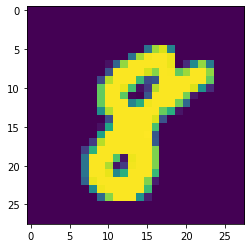

Output of filter 3


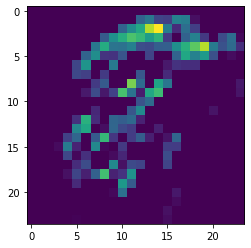

Filter 3


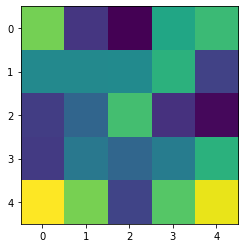

Output of filter 9


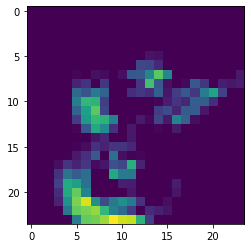

Filter 9


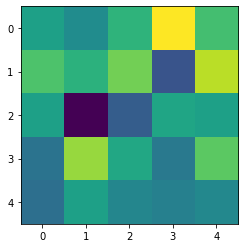

Output of filter 22


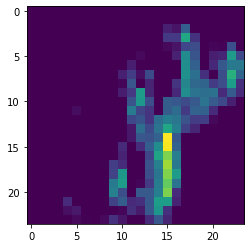

Filter 22


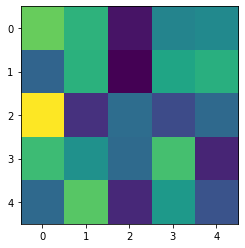

In [38]:
weights = pickle.load(open('weights/weights4.p', 'rb'))

def model(X, weights):
    convolutional_layer_1 = rectify(conv2d(X, weights[0]))
    subsampling_layer_1 = max_pool2d(convolutional_layer_1, (2, 2))
    drop_layer_1 = dropout(subsampling_layer_1, 0.2)

    convolutional_layer_2 = rectify(conv2d(drop_layer_1, weights[1]))
    subsampling_layer_2 = max_pool2d(convolutional_layer_2, (2, 2))
    drop_layer_2 = dropout(subsampling_layer_2, 0.2)

    convolutional_layer_3 = rectify(conv2d(drop_layer_2, weights[2]))
    subsampling_layer_3 = max_pool2d(convolutional_layer_3, (2, 2))
    drop_layer_3 = dropout(subsampling_layer_3, 0.2)

    h = torch.reshape(drop_layer_3, (-1, 128))
    h2 = rectify(h @ weights[3])
    pre_softmax = h2 @ weights[4]
    return pre_softmax, convolutional_layer_1, convolutional_layer_2, convolutional_layer_3
    
if __name__ == '__main__':
    X, y = iter(dataloader).next()
    pred, c1, c2, c3 = model(X.reshape(mb_size, 1, 28, 28), weights)
    print("Input Image:")
    plt.figure()
    plt.imshow(X[0, 0])
    plt.show()
    for i in [3, 9, 22]:
        print(f"Output of filter {i}")
        plt.figure()
        plt.imshow(c1.detach().numpy()[0, i])
        plt.show()
        print(f"Filter {i}")
        plt.figure()
        plt.imshow(weights[0].detach().numpy()[i,0])
        plt.show()

First of these filters recognises diagonal borders, the second one horizontal ones, and the last one vertical borders.

In [39]:
def model(X, weigths):
    convolutional_layer_0 = rectify(conv2d(X, weigths[0]))
    convolutional_layer_1 = rectify(conv2d(convolutional_layer_0, weigths[1]))
    subsampling_layer_1 = max_pool2d(convolutional_layer_1, (2, 2))
    drop_layer_1 = dropout(subsampling_layer_1, 0.2)

    convolutional_layer_2 = rectify(conv2d(drop_layer_1, weigths[2]))
    subsampling_layer_2 = max_pool2d(convolutional_layer_2, (2, 2))
    drop_layer_2 = dropout(subsampling_layer_2, 0.2)

    convolutional_layer_3 = rectify(conv2d(drop_layer_2, weigths[3]))
    subsampling_layer_3 = max_pool2d(convolutional_layer_3, (2, 2))
    drop_layer_3 = dropout(subsampling_layer_3, 0.2)

    h = torch.reshape(drop_layer_3, (-1, 128))
    h2 = rectify(h @ weigths[4])
    pre_softmax = h2 @ weigths[5]
    return pre_softmax

weigths = init_weights([(32, 1, 3, 3), (32, 32, 3, 3), (64, 32, 5, 5), (128, 64, 2, 2), (128, 625), (625, 10)])
optimizer = RMSprop(weigths)

if __name__ == '__main__':
    # put this into a training loop over 100 epochs
    for i in range(11):
        print("Epoch: {}".format(i+1))
        avg_train_loss = 0.
        for (j, (X, y)) in enumerate(dataloader):
            #trainX = trainX.reshape(-1, 1, 28, 28) #training data
            #testX = testX.reshape(-1, 1, 28, 28) #test data
            noise_py_x = model(X.reshape(mb_size, 1, 28, 28), weigths)# model(X.reshape(mb_size , 784), w_h, w_h2, w_o)
            optimizer.zero_grad()
            # the cross-entropy loss function already contains the softmax
            cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
            avg_train_loss += cost
            cost.backward()
            optimizer.step()

        pickle.dump(weigths, open(f'weights/weights_new{i}.p', 'wb'))

        print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))

        # no need to calculate gradients for validation
        with torch.no_grad():
            avg_test_loss = 0.
            for (k, (X, y)) in enumerate(test_loader):
                noise_py_x = model(X.reshape(mb_size, 1, 28, 28), weigths)
                cost = torch.nn.functional.cross_entropy(noise_py_x, y, reduction="mean")
                avg_test_loss += cost

            print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))

Epoch: 1
Average Train Loss: 1.3161259889602661
Average Test Loss: 0.27058660984039307
Epoch: 2
Average Train Loss: 0.22211255133152008
Average Test Loss: 0.15817265212535858
Epoch: 3
Average Train Loss: 0.16599255800247192
Average Test Loss: 0.1482958197593689
Epoch: 4
Average Train Loss: 0.14500762522220612
Average Test Loss: 0.1403220146894455
Epoch: 5
Average Train Loss: 0.14105579257011414
Average Test Loss: 0.13412249088287354
Epoch: 6
Average Train Loss: 0.14799754321575165
Average Test Loss: 0.14694824814796448
Epoch: 7
Average Train Loss: 0.16554324328899384
Average Test Loss: 0.21795403957366943
Epoch: 8
Average Train Loss: 0.1836724728345871
Average Test Loss: 0.1936095803976059
Epoch: 9
Average Train Loss: 0.2062862366437912
Average Test Loss: 0.15046320855617523
Epoch: 10
Average Train Loss: 0.21044883131980896
Average Test Loss: 0.2820557951927185
Epoch: 11
Average Train Loss: 0.22570346295833588
Average Test Loss: 0.30053532123565674


Added a layer at the beginning, and reduced the size of the first two to 3, which gives us an additional 9216 weights, and improves performance.

In [43]:
print("MLP without dropout\n")
print("Final train loss: \t0.05236726254224777 \nFinal test loss: \t0.7477063536643982\n\n")
print("MLP with dropout\n")
print("Final train loss: \t1.380552053451538 \nFinal test loss: \t0.5611656904220581\n\n")
print("Base CNN\n")
print("Average Train Loss: \t0.19016674160957336\nAverage Test Loss: \t0.16256782412528992\n\n")
print("Adjusted CNN\n")
print("Average Train Loss: \t0.14105579257011414\nAverage Test Loss: \t0.13412249088287354")

MLP without dropout

Final train loss: 	0.05236726254224777 
Final test loss: 	0.7477063536643982


MLP with dropout

Final train loss: 	1.380552053451538 
Final test loss: 	0.5611656904220581


Base CNN

Average Train Loss: 	0.19016674160957336
Average Test Loss: 	0.16256782412528992


Adjusted CNN

Average Train Loss: 	0.14105579257011414
Average Test Loss: 	0.13412249088287354
